
# Basics V - PyTorch and Tensorflow

PyTorch and Tensorflow are the most well-known libraries for implementing, training, and running inference for deep models. In this tutorial, we will learn the basic principles of these frameworks and glance at an example of a classification task for biomedical image data.

&nbsp;

<center>
<img src="https://drive.google.com/uc?export=view&id=1MptZuXd56MpYRanv3wGMRBddITe6jXz_" width="200" hspace="30" vspace="11">
<img src="https://drive.google.com/uc?export=view&id=1x6KzXrHB6CT0fMV1Tm-41FR4c7lI_Omk" width="200" hspace="30">

</center>





&nbsp;

Some differences between the two platforms may sway you into learning one or the other if you have not a preferred one already. PyTorch often feels more flexible, pythonic, and lighter than TensorFlow. Someone used to the python programming language may find it easier to learn. In contrast, Tensorflow has better visualization features with tensorboard and facilitates moving models from development to production. Over the years, these differences have been attenuated, with TensorFlow's eager execution, PyTorch's support of tensorboard, among other factors.

&nbsp;

**There are many materials which you can use to learn any of this frameworks.**

We recommend you follow [this one](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) for PyTorch.

You might also want to check [this one](https://www.tensorflow.org/tutorials/keras/classification) out if you want to learn Tensorflow.



### Outline


1.   The Must-haves of a deep learning framework
2.   Melanoma diagnosis with MobileNet in PyTorch

## 1. Must-haves of a deep learning framework

In a way, Tensorflow and PyTorch are similar to numpy or other frameworks which you may be familiar with. We can use these libraries to do operations with vectors, such as pointwise operations, matrix multiplications, and others.

Run the code below for each of the three frameworks and check the result is the same for all frameworks.

In [ ]:
import numpy as np
import torch
import tensorflow as tf

framework = "torch"

if framework == "tensorflow":
  a = np.array([1,2,3], dtype=np.float32).reshape([3, 1])
  b = a * 2
  result = np.dot(a, b.T)

elif framework == "torch":
  a = torch.tensor([1,2,3], dtype=torch.float32).view([3, 1])
  b = a * 2
  result = torch.matmul(a, b.T)

elif framework == "tensorflow":
  a = tf.reshape(tf.constant([1,2,3], dtype=tf.float32), [3, 1])
  b = a * 2
  result = tf.matmul(a, tf.transpose(b))

print(f"Using {framework}:\n", result)

Using torch:
 tensor([[ 2.,  4.,  6.],
        [ 4.,  8., 12.],
        [ 6., 12., 18.]])


However, when it comes to deep learning frameworks, there are a few critical must-have functionalities. Typically, neural networks are composed of **many simple functions/layers** put together in an architecture. These are optimized using **gradient descent**, where gradients are calculated using **backpropagation**. Also, models are run for many iterations, increasing execution performance's importance. Typically this is addressed by the use of GPUs, which provide critical speedups for machine learning models.

&nbsp;

<center>
<img src="https://drive.google.com/uc?export=view&id=1Hh-HJwXQdAm2mESorc5V8dFi7I_Hb7b2" width="350" hspace="30">
</center>

&nbsp;

These frameworks' two main advantages over NumPy are automatic differentiation and GPU acceleration. Additionally, the fact that common operations and models are already implemented is an important feature we will cover later.

### Automatic Differentiation

Contrary to NumPy, every operation in PyTorch and TensorFlow has a gradient function that can be easily accessed. Further, when composing several operations, the frameworks keep track of the computational graph so that we can compute the gradient for all the parameters used in the process. This feature is called automatic differentiation and relies on the backpropagation technique.

The syntax used to compute the gradient is different for Pytorch and TensorFlow:

In [ ]:
import numpy as np
img_base = np.random.randn(1, 1, 20, 20).astype(np.float32)
w_base = np.random.randn(1, 1, 3, 3).astype(np.float32)

# PyTorch
import torch
img = torch.tensor(img_base)
w = torch.tensor(w_base, requires_grad=True)  # we create a tensor that requires gradient
out = torch.nn.functional.conv2d(img, w)                      # operation 1
out = torch.mean(out)                                         # operation 2

print("PyTorch")
print("\tInitially:", w.grad)
out.backward()
print("\tAfter backward:\n", w.grad)

# TensorFlow
import tensorflow as tf
img = tf.constant(img_base.transpose([0, 2, 3, 1]))
w = tf.Variable(w_base.transpose([2, 3, 0, 1]))

with tf.GradientTape() as tape:
  out = tf.nn.conv2d(img, w, 1, "VALID")                       # operation 1
  out = tf.math.reduce_mean(out)                               # operation 2

grad = tape.gradient(out, w)
print("TensorFlow")
print("\tAfter backward:\n", grad[:,:,0,0])

PyTorch
	Initially: None
	After backward:
 tensor([[[[0.0244, 0.0289, 0.0114],
          [0.0247, 0.0282, 0.0122],
          [0.0240, 0.0333, 0.0096]]]])
TensorFlow
	After backward:
 tf.Tensor(
[[0.02437484 0.02889138 0.01139389]
 [0.02473907 0.02821025 0.01217808]
 [0.02396985 0.03328163 0.00958177]], shape=(3, 3), dtype=float32)


By now, you have probably noticed some differences between the implementation of the two platforms. In PyTorch, we do not need a context to let the platform know that we are interested in computing the gradients later. It is assumed that we will do it, so the computational graph is saved by default. Note that the **tape.gradient** method can be used with multiple variables (e.g., **tape.gradient(loss, list_of_trainable_variables)**).

&nbsp;

Notice also the difference in the default format of the filter and the input image:

| Syntax      | Input      | Filters |
| ----------- | -----------|---------|
| PyTorch     | [N,C,H,W]      |[C1,C2,H,W,]     |
| TensorFlow  | [N,H,W,C]       |[H,W,C1,C2]     |

&nbsp;


By default, the gradients in PyTorch are accumulated, i.e., summed to **.grad** field, rather than set. This means that if you do not zero out the **.grad** field, the result of the backward operation will not be the correct gradient. Tipically we use a method that zeros out all tracked variables as seen in a later part of this tutorial. But for illustration, let's check the code below. Feel free to uncomment the two lines that set the gradient to zero.

In [ ]:
import numpy as np
img_base = np.random.randn(1, 1, 20, 20).astype(np.float32)
w_base = np.random.randn(1, 1, 3, 3).astype(np.float32)

# PyTorch
import torch
img = torch.tensor(img_base)
w = torch.tensor(w_base, requires_grad=True)  # we create a tensor that requires gradient

for i in range(3):
  out = torch.nn.functional.conv2d(img, w)                      # operation 1
  out = torch.mean(out)                                         # operation 2
  #if w.grad is not None:
  #  w.grad.data.zero_()
  out.backward()
  print(f"\tAfter backward {i+1}:\n", w.grad)

	After backward 1:
 tensor([[[[-0.0097,  0.0028, -0.0164],
          [-0.0099,  0.0030, -0.0271],
          [ 0.0090,  0.0173, -0.0001]]]])
	After backward 2:
 tensor([[[[-0.0194,  0.0055, -0.0329],
          [-0.0198,  0.0060, -0.0541],
          [ 0.0179,  0.0345, -0.0002]]]])
	After backward 3:
 tensor([[[[-0.0291,  0.0083, -0.0493],
          [-0.0297,  0.0090, -0.0812],
          [ 0.0269,  0.0518, -0.0003]]]])


Finally, it is important to note that in some cases you do not care about the gradient, you just need to run the model. In those cases, for performance you can disable the gradient, as shown in the next example. Feel free to try to obtain the gradients and check the errors returned.

In [ ]:
import numpy as np
img_base = np.random.randn(1, 1, 20, 20).astype(np.float32)
w_base = np.random.randn(1, 1, 3, 3).astype(np.float32)

# PyTorch
import torch
img = torch.tensor(img_base)
w = torch.tensor(w_base, requires_grad=True)  # we create a tensor that requires gradient
with torch.no_grad():
  out = torch.nn.functional.conv2d(img, w)                      # operation 1
  out = torch.mean(out)                                         # operation 2

#out.backward()


# TensorFlow
import tensorflow as tf
img = tf.constant(img_base.transpose([0, 2, 3, 1]))
w = tf.Variable(w_base.transpose([2, 3, 0, 1]))
out = tf.nn.conv2d(img, w, 1, "VALID")                          # operation 1
out = tf.math.reduce_mean(out)                                  # operation 2

# Notice that if we use tape, we are reusing the variable of the previous example.
# Therefore, we renamed it in this example to new_tape

#grad = new_tape.gradient(out, w)

### GPU Acceleration

Deep learning models are optimized iteratively over the training data. The forward and backward passes can run millions of times for a model trained from scratch. Computationally and environmentally, this is a heavy burden [carbon footprint](https://mlco2.github.io/impact/).

&nbsp;

<center>
<img src="https://drive.google.com/uc?export=view&id=1pB1hZiSjmHn9eMsETi4HvrUVLNrXTG5J" width="400" hspace="30">

Performance comparison between different processors, according to [here](https://developer.nvidia.com/blog/inference-next-step-gpu-accelerated-deep-learning/).
</center>

&nbsp;

Hardware has become one of the most critical factors in developing deep learning models. Both PyTorch and TensorFlow provide excellent support for the use of GPUs. In the following example, we will repeat the operations above but this time using GPU execution. For this part of the tutorial, please ensure that in the upper menu, you select **Runtime** and then **Change runtime time**. When collab prompts you, please select GPU.

&nbsp;

GPU acceleration is internally supported using CUDA on both frameworks. Although not covered here, you can also use this programming interface to implement your own operations. Notice however that this requires a much more lower-level knowledge than what is required to learn PyTorch and TensorFlow.

In [ ]:
import numpy as np
img_base = np.random.randn(1, 1, 20, 20).astype(np.float32)
w_base = np.random.randn(1, 1, 3, 3).astype(np.float32)

device = "cuda:0"
# PyTorch
import torch
img = torch.tensor(img_base)
w = torch.tensor(w_base, requires_grad=True)
img = img.to(device)
w = w.to(device)

out = torch.nn.functional.conv2d(img, w)                      # operation 1
out = torch.mean(out)                                         # operation 2
print("PyTorch after computation:", out.device)
print("PyTorch moving to cpu:", out.detach().cpu().device)

# TensorFlow
import tensorflow as tf
img = tf.constant(img_base.transpose([0, 2, 3, 1]))
w = tf.Variable(w_base.transpose([2, 3, 0, 1]))


with tf.GradientTape() as tape:
  #with tf.device('/CPU:0'):
    out = tf.nn.conv2d(img, w, 1, "VALID")                       # operation 1
    out = tf.math.reduce_mean(out)                               # operation 2

print("Tensorflow device used:", out.device)

PyTorch after computation: cuda:0
PyTorch moving to cpu: cpu
Tensorflow device used: /job:localhost/replica:0/task:0/device:GPU:0


As you can see, TensorFlow already uses the GPU by default. If we want, we can explicitly set the device. In PyTorch, operations are performed in the device where all the tensors are. In the example above, we set the input image and filter to the cuda:0 device. Then, any operation using these two inputs runs on cuda:0. PyTorch will raise an error if one input is on the GPU and another on the CPU. Let us test the speed-ups we can obtain by using this strategy.

In [ ]:
from time import time
import numpy as np
import torch
import tensorflow as tf


n1 = 2048
n2 = 2048
n3 = 2048
iterations = 100
t = time()
time_list = []

def count_time(func):
  for i in range(iterations):
    func()
    if i!=0:
      time_list.append(time()-t)
    t = time()
  return "{:.3f}".format(np.mean(time_list)) + u"\u00B1" +  "{:.3f}".format(np.std(time_list))

torch_cpu = lambda : torch.matmul(torch.rand(n1, n2, device="cpu"), torch.rand(n2, n3, device="cpu"))
torch_gpu = lambda : torch.matmul(torch.rand(n1, n2, device="cuda:0"), torch.rand(n2, n3, device="cuda:0")) 
tf_code = lambda : tf.linalg.matmul(tf.random.uniform((n1, n2)), tf.random.uniform((n2, n3)))

print(f"PyTorch on CPU (time in s): ", count_time(torch_cpu))
print(f"PyTorch on GPU (time in s): ", count_time(torch_gpu))

with tf.device('/CPU:0'):
  print(f"TensorFlow on CPU (time in s): ", count_time(tf_code))

with tf.device('/GPU:0'):
  print(f"TensorFlow on GPU (time in s): ", count_time(tf_code))

PyTorch on CPU (time in s):  0.193±0.045
PyTorch on GPU (time in s):  0.097±0.102
TensorFlow on CPU (time in s):  0.127±0.099
TensorFlow on GPU (time in s):  0.095±0.102


It is important to mention that depending on the hardware you have, this speedup may be more or less significative. In a platform like colab we have little control over this. Feel free to run this example on other machines and evaluate the impact of using a GPU. You can also add other functions, such as the very common convolution operation.

### Common Operations and Architectures

On top of these low-level features, both PyTorch and Tensorflow already provide widely tested implementations of standard functions, layers, and models. We will quickly go over some of them.

&nbsp;

#### <center> Packages </center>

| Functionality     | PyTorch    | TensorFlow |
| ----------- | -----------|------------|
| Layers | torch.nn |tf.keras.layers|
| Datasets | torchvision.datasets (separate)|tf.keras.datasets|
| Optimizers | torch.optim |tf.keras.optimizers|
| Metrics | torchmetrics (separate) |tf.keras.metrics|
| Losses | torch.nn |tf.keras.losses|


#### <center> Models </center>
##### Image Classification


| Model      | PyTorch      | TensorFlow |
| ----------- | -----------|---------|
| VGG16     | torchvision.models.vgg16(pretrained=True)      | tf.keras.applications.VGG16(weights="imagenet")    |
| ResNet-50  | torchvision.models.resnet50(pretrained=True)       |tf.keras.applications.ResNet50(weights="imagenet")     |
| DenseNet-169  | torchvision.models.densenet169(pretrained=True)       |tf.keras.applications.DenseNet169(weights="imagenet")    |
| ConvNeXt-base  | torchvision.models.convnext_base(pretrained=True)        |tf.keras.applications.convnext.ConvNeXtBase(weights="imagenet")     |

&nbsp;

Additionally, PyTorch and TensorFlow provide hubs where models can be uploaded and downloaded. These repositories have a lot of different architectures, trained with different configurations. You can quickly glance over the following examples to load a detection model in each framework.

In [ ]:
import os
import torch
import tensorflow_hub as hub

os.environ['TFHUB_CACHE_DIR'] = 'tmp'
module_handle = "https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1"
fasterrcnn = hub.load(module_handle)
print(fasterrcnn)

!pip install yacs
yolo_model = torch.hub.load('hustvl/yolop', 'yolop', pretrained=True)
print(yolo_model)


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f0fef8361d0>
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/hustvl/yolop/archive/main.zip" to /root/.cache/torch/hub/main.zip


MCnet(
  (model): Sequential(
    (0): Focus(
      (conv): Conv(
        (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): Hardswish()
      )
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): Hardswish()
    )
    (2): BottleneckCSP(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): Hardswish()
      )
      (cv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (cv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (cv4): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), st

Make sure you go to https://pytorch.org/hub/ and https://tfhub.dev/ and check the available models.

&nbsp;

&nbsp;


In these frameworks you will also find tools to train your models in a very simple way. Let's look the problem that is often considered the "hello-world" of deep learning, digit recognition.

&nbsp;

<center>
<img src="https://drive.google.com/uc?export=view&id=1r4q0BX7H5PyU6hJ82-6h8bDBlrfkPi2q" width="300" hspace="30">

  [MNIST](http://yann.lecun.com/exdb/mnist/) datasest.
</center>

&nbsp;

The following code is part of an official tutorial to PyTorch Lightning, you can read more on it [here](https://pytorch-lightning.readthedocs.io/en/latest/notebooks/lightning_examples/mnist-hello-world.html).

In [ ]:
!pip install pytorch_lightning
import os
import pandas as pd
import seaborn as sn
import torch
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)


model = LitMNIST()
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=20,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 9.0 MB/s 
     |████████████████████████████████| 140 kB 31.8 MB/s 
     |████████████████████████████████| 596 kB 38.4 MB/s 
     |████████████████████████████████| 419 kB 50.0 MB/s 
     |████████████████████████████████| 1.1 MB 54.5 MB/s 
     |████████████████████████████████| 271 kB 64.8 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 144 kB 63.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

We can go ahead and check the training curves which will give us an idea if the model has already converged. Notice that if you run this experiment multiple times, PyTorch Lightning will save the logs in separate folders so you may have to change the path below.

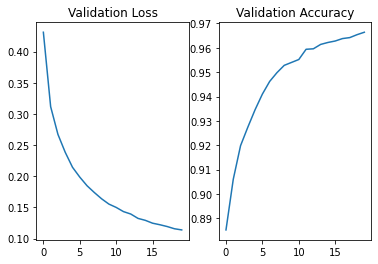

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

path = "logs/lightning_logs/version_0/metrics.csv"
metrics = pd.read_csv(path)

plt.subplot(1, 2, 1)
plt.title("Validation Loss")
plt.plot(metrics['epoch'], metrics['val_loss'])

plt.subplot(1, 2, 2)
plt.title("Validation Accuracy")
plt.plot(metrics['epoch'], metrics['val_acc'])

plt.show()


Similarly, if we wanted to use keras, you would use the following syntax.

In [ ]:
# Adapted from https://keras.io/examples/vision/mnist_convnet/

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)         

## 2. Melanoma diagnosis with MobileNet in PyTorch

Now let's look at the following example.
It is based on this [code](https://github.com/tomealbuquerque/ordinal-losses) and covers the main topics on a classification task:


| Class  | Clinical Meaning |  
|---|---| 
|  0 | Common Nevus  | 
|  1 | Atypical Nevus | 
|  2 | Melanoma  |


## Target

### Common Nevus
<div>
<img src="https://drive.google.com/uc?export=view&id=1URtHY7IhelBAXao4yXWjJQ8HCkZW5lLk" width="300"/>
</div>

### Atypical Nevus
<div>
<img src="https://drive.google.com/uc?export=view&id=13a4oUE-gNNq-qPKI_viCFDtzrrnLWVyp" width="300"/>
</div>

### Melanoma
<div>
<img src="https://drive.google.com/uc?export=view&id=1y8qBhNDFK5DKlo5xDsO041__5lp7N2YX" width="300"/>
</div>




### Load Data into Colab

In [ ]:
#package to import google drive files to colab
!pip install PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':"1Wb3H6ABEyeIlc2r5UPocWkzLnXHvKhmJ"})   # replace the id with id of file you want to access
file_id= "1Wb3H6ABEyeIlc2r5UPocWkzLnXHvKhmJ"
downloaded.GetContentFile("dataset.zip")
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

#import pdb 
#pdb.set_trace()
#downloaded.GetContentFile('k7.pickle')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

### Data Loading and Model Optimization

In [ ]:
#Main pipeline for multiclass classification
#import libraries
import numpy as np
from time import time
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
from torchvision import models, transforms
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import os 



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters to tune
#number of classes 
K = 3
#number of images per mini-batch
batchsize=16
#epochs to finish the train 
epochs=15
#learning rate
lr=1e-4
#pre-trained architecture
architecture='mobilenet_v2'

#Prepare dataset loader
class MyDataset(Dataset):
    def __init__(self, type, transform, K):
        df = pd.read_excel("PH2_dataset.xlsx")
        x = df["Image Name"]
        y = df["Label"]
        self.type = type
        if type == "train":
          self.x, _, self.y, _ = train_test_split(x, y, test_size=0.10, random_state=42)
        else:
          _, self.x, _, self.y = train_test_split(x, y, test_size=0.10, random_state=42)
        self.transform = transform

    def __getitem__(self, i):
        X = self.transform(np.array(Image.open(os.path.join("images",self.x.iloc[i]) + ".bmp")))
        Y = self.y.iloc[i]
        return X, Y

    def __len__(self):
        return len(self.x)

#train transforms
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomAffine(180, (0, 0.1), (0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

#val transforms
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112,112)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

#dataloaders
tr_ds = MyDataset('train', train_transforms, K)
tr = DataLoader(tr_ds, batchsize, True)#random selection of images - True
ts_ds = MyDataset('test', val_transforms, K)
ts = DataLoader(ts_ds, batchsize)

#loss
ce = nn.CrossEntropyLoss()

# Model
class Base(nn.Module):
    def __init__(self, pretrained_model, n_outputs):
        super().__init__()
        self.n_outputs = n_outputs
        model = getattr(models, pretrained_model)(pretrained=True) #using transfer learning from a pretrained model - True
        model = nn.Sequential(*tuple(model.children())[:-1])
        last_dimension = torch.flatten(model(torch.randn(1, 3, 112, 112))).shape[0]
        model.requires_grad= False
        self.model = nn.Sequential(
            model,
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(last_dimension, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, n_outputs)
        )

    def forward(self, x):
        return self.model(x)

    def loss(self, Yhat, Y):
        return ce(Yhat, Y)

    def to_proba(self, Yhat):
        return F.softmax(Yhat, 1)

    def to_classes(self, Phat):
        return Phat.argmax(1)

#test cycle
def test(val):
    model.eval()
    val_avg_acc = 0
    with torch.no_grad():
      for X, Y in tqdm(val):
          X = X.to(device)
          Y = Y.to(device, torch.int64)
          Yhat = model(X)
          Khat = model.to_classes(model.to_proba(Yhat))
          val_avg_acc += (Y == Khat).float().mean() / len(val)
    return val_avg_acc

#train cycle
def train(tr, val, epochs=epochs, verbose=True):
    for epoch in range(epochs):
        if verbose:
            print(f'* Epoch {epoch+1}/{epochs}')
        tic = time()
        model.train()
        avg_acc = 0
        avg_loss = 0
        for X, Y in tqdm(tr):
            X = X.to(device)
            Y = Y.to(device, torch.int64)
            opt.zero_grad()
            Yhat = model(X)
            loss = model.loss(Yhat, Y)
            loss.backward()
            opt.step()
            Khat = model.to_classes(model.to_proba(Yhat))
            avg_acc += (Y == Khat).float().mean() / len(tr)
            avg_loss += loss / len(tr)
        dt = time() - tic
        out = ' - %ds - Loss: %f, Acc: %f' % (dt, avg_loss, avg_acc)
        if val:
            model.eval()
            out += ', Test Acc: %f' % test(val)
        if verbose:
            print(out)
        scheduler.step(avg_loss)

#get output probabilities from the model
def predict_proba(data):
    model.eval()
    Phat = []
    with torch.no_grad():
        for X, _ in data:
            phat = model.to_classes(model.to_proba(model(X.to(device))))
            Phat += list(phat.cpu().numpy())
    return Phat

#Give to the model the architecture and number of classes (K)
model = Base(architecture, K)
#put the model on 'GPU' or 'CPU'
model = model.to(device)
#Define optimizer and scheduler 
opt = optim.Adam(model.parameters(), lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, verbose=True)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
#Start the training process
train(tr, ts)

* Epoch 1/15


100%|██████████| 2/2 [00:00<00:00, 15.69it/s]


 - 1s - Loss: 1.086264, Acc: 0.348958, Test Acc: 0.312500
* Epoch 2/15


100%|██████████| 2/2 [00:00<00:00, 15.81it/s]


 - 1s - Loss: 1.003187, Acc: 0.510417, Test Acc: 0.593750
* Epoch 3/15


100%|██████████| 2/2 [00:00<00:00, 17.02it/s]


 - 1s - Loss: 0.912222, Acc: 0.531250, Test Acc: 0.687500
* Epoch 4/15


100%|██████████| 2/2 [00:00<00:00, 15.52it/s]


 - 1s - Loss: 0.805012, Acc: 0.630208, Test Acc: 0.687500
* Epoch 5/15


100%|██████████| 2/2 [00:00<00:00, 15.67it/s]


 - 1s - Loss: 0.667201, Acc: 0.718750, Test Acc: 0.718750
* Epoch 6/15


100%|██████████| 2/2 [00:00<00:00, 15.80it/s]


 - 1s - Loss: 0.553081, Acc: 0.770833, Test Acc: 0.718750
* Epoch 7/15


100%|██████████| 2/2 [00:00<00:00, 16.20it/s]


 - 1s - Loss: 0.541374, Acc: 0.807292, Test Acc: 0.781250
* Epoch 8/15


100%|██████████| 2/2 [00:00<00:00, 16.65it/s]


 - 1s - Loss: 0.431749, Acc: 0.859375, Test Acc: 0.781250
* Epoch 9/15


100%|██████████| 2/2 [00:00<00:00, 16.22it/s]


 - 1s - Loss: 0.414562, Acc: 0.885417, Test Acc: 0.781250
* Epoch 10/15


100%|██████████| 2/2 [00:00<00:00, 16.15it/s]


 - 1s - Loss: 0.314020, Acc: 0.869792, Test Acc: 0.781250
* Epoch 11/15


100%|██████████| 2/2 [00:00<00:00, 16.84it/s]


 - 1s - Loss: 0.316446, Acc: 0.906250, Test Acc: 0.875000
* Epoch 12/15


100%|██████████| 2/2 [00:00<00:00, 16.72it/s]


 - 1s - Loss: 0.219488, Acc: 0.963542, Test Acc: 0.843750
* Epoch 13/15


100%|██████████| 2/2 [00:00<00:00, 17.38it/s]


 - 1s - Loss: 0.236317, Acc: 0.911458, Test Acc: 0.718750
* Epoch 14/15


100%|██████████| 2/2 [00:00<00:00, 15.51it/s]


 - 1s - Loss: 0.116212, Acc: 0.968750, Test Acc: 0.750000
* Epoch 15/15


100%|██████████| 2/2 [00:00<00:00, 14.87it/s]

 - 1s - Loss: 0.156450, Acc: 0.968750, Test Acc: 0.750000


###Evaluate Model Performance

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.88      0.78         8
         1.0       0.60      0.50      0.55         6
         2.0       1.00      0.83      0.91         6

    accuracy                           0.75        20
   macro avg       0.77      0.74      0.74        20
weighted avg       0.76      0.75      0.75        20

Confusion Matrix:


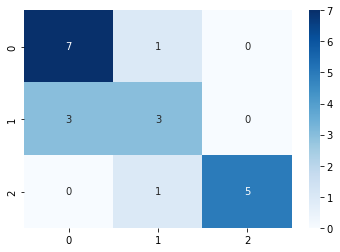

In [ ]:
#evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel("PH2_dataset.xlsx")
x = df["Image Name"]
y = df["Label"]
y_pred=predict_proba(ts)
_,_,_,y_true =  train_test_split(x, y, test_size=0.10, random_state=42)
print('Classification Report:\n', classification_report(y_true, y_pred))

print('Confusion Matrix:')
cm = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')
plt.show()

## Topics not covered - PyTorch

### Data Augmentation - Albumentations

```
#or using Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.Resize(224, 224), 
    A.RandomCrop(128, 128),
    A.HorizontalFlip(),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

```

### Custom Layers/Models;


Writing custom models is easy in PyTorch.
You need to:


1.   Extend the nn.Module class
2.   Implement the \_\_init__ method
3.   Implement the forward method

You can also use nn.Module's inside your nn.Module. This is how available architectures are implemented in PyTorch.

Let's look at the following example:

```
from torch import nn

class Model_example(nn.Module):
    def __init__(self, pretrained_model, n_outputs):
        super().__init__()
        self.n_outputs = n_outputs
        model = getattr(models, pretrained_model)(pretrained=True)
        #remove last layer from pre-trained model 
        model = nn.Sequential(*tuple(model.children())[:-1])
        #get last dimension of the model
        last_dimension = torch.flatten(model(torch.randn(1, 3, 224, 224))).shape[0]
        self.model = nn.Sequential(
            model,
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(last_dimension, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_outputs)
        )

    def forward(self, x):
        return self.model(x)
```

By doing this you can use functions like:
* model(x)  # forward
* torch.save(model.state_dict(), path)  # save model
* model.load_state_dict(torch.load(path))  # load model
* model.parameters()  # for the optimizer for example
* model.train()
* model.eval()


# Closing remarks


## Some tips!

* save your experiments - training takes time, and sometimes you want to check something later or reuse your model. As such, you should save your model, hyperparameters, data, training curves, etc., and keep it.

**Example:** you trained a few models, evaluated their accuracy, and you got rid of them. Later, you were asked to assess the rocAUC too. If you discarded your model, you would have to retrain, which can take a few days.

* the devil is in the details - many things in deep learning depend on little details. Errors are often silent. Due to this, you should adopt a defensive posture and evaluate and debug intermediate results as much as possible. In the end, you will save time.

* do not reinvent the wheel unless you are having fun - many of the things you need are either implemented on PyTorch or other repositories. If you are implementing something by yourself, make sure you are wasting time because you want to.

## What can I use besides Pytorch? 

### Fast.AI

https://www.fast.ai/

### Pytorch Lightning 

https://www.pytorchlightning.ai/

### Jax 

https://github.com/google/jax

## See you in VISUM 2022

Pedro Neto

Eduardo Castro

<center><h1>Thank you!!</h1></center>
